## Note to graders
#### For lemmatizing process, words like won't, can't, don't are tokenized as wo, ca, do, n't. I could have handled it by removing those but I felt they carry important information. So, I expanded all the contractions and tokenized. Results might slightly differ because of that. 

In [1]:
import nltk
!pip install contractions
import contractions
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ravin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ravin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### CSCE 670 :: Information Storage & Retrieval :: Texas A&M University :: Spring 2023


# Homework 1:  Lyrical Search Engine

### 100 points [9% of your final grade]

### Due: February 10 (Friday) by 11:59pm

*Goals of this homework:* In this homework you will get first hand experience building a text-based mini search engine. In particular, there are three main learning objectives: (i) the basics of tokenization (e.g. stemming, case-folding, etc.) and its effect on information retrieval; (ii) basics of index building and Boolean retrieval; and (iii) basics of the Vector Space model and ranked retrieval.

*Submission instructions (eCampus):* To submit your homework, rename this notebook as `UIN_hw1.ipynb`. For example, my homework submission would be something like `555001234_hw1.ipynb`. Submit this notebook via eCampus (look for the homework 1 assignment there). Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit.

*Late submission policy:* For this homework, you may use as many late days as you like (up to the 5 total allotted to you).

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. 

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Dataset: Genius Lyrics Dataset

We are providing you with a small collection of the lyrics to 200 songs collected from Genius (https://genius.com/). The full data was originally collected by Austin Benson at Cornell (https://www.cs.cornell.edu/~arb/data/genius-expertise/). For this homework, you can use just the small set we provide: **lyrics_200.jl**. You should treat each song as a unique document to be indexed by your system. You can download the data from eCampus to your local filesystem. We're going to use these lyrics as the basis of a Lyrical Search Engine!

# Part 1: Read and Parse the Lyrics Data (20 points)

Recall how we handled file input in Homework 0? Well, here, our goal is to read the lyrics so that we can begin to tokenize them later. For this step, you should read the dataset and print the lyrics. Note that our dataset is in JSON lines format, meaning that each line break separates an entry in JSON format. A document looks like:

{'songs': 'Linkin-park-in-the-end-lyrics', 'lyrics': '\n\n[Verse 1: Mike Shinoda & Chester Bennington]\nIt starts...'}

For this homework, you should treat the lyrics as a document and the songs as the document ID.

Your output should look like this:

DocumentID Document

Linkin-park-in-the-end-lyrics \n\n[Verse 1: Mike Shinoda & Chester Bennington]\nIt starts...

... ...

In [2]:
# your code here
import pandas as pd
import json
import os

def json_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

cur_dir = os.getcwd()
#print(cur_dir)
file_path = str(cur_dir) + '/lyrics_200.jl'
df = json_to_df(file_path)
col_names = ['DocumentID', 'Document']
df.columns = col_names
df.head()

,DocumentID,Document
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"\n\n[Production by J Dilla, Erykah Badu, and J..."
1,Daniel-caesar-we-find-love-lyrics,\n\n[Verse 1]\nYou don't love me anymore\nLet'...
2,Florence-the-machine-hunger-lyrics,"\n\n[Intro]\nOoh, ooh, ooh-ooh, ooh\nOoh, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,\n\n[Verse 1]\nHold me\nLike the River Jordan\...
4,Partynextdoor-not-nice-lyrics,\n\n[Intro: PARTYNEXTDOOR]\nOh-oh-oh-oh\nOh-oh...


Now that you can read the documents, let's move on to tokenization. You should lowercase all words. Your parser needs to also provide the following three pre-processing options:
1. Remove background vocals (strings in parentheses) and song structure indicators 
(strings in square brackets, e.g., [Verse 1: Mike Shinoda & Chester Bennington])
2. Lemmatization: use nltk Lemmatizer `from nltk.stem import WordNetLemmatizer`
3. Remove any other strings that you think are less informative or noisy, e.g., non-word vocal sounds, non-character.

Please note that you should stick to the stemming package listed above. Otherwise, given the same query, the results generated by your code can be different from others. For tokenization, you could use [nltk.tokenize.word_tokenize](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize) or you can write your own.

## Observations (3 * 4 = 12 points)

Once you have your parser working, you should 

* print the first two documents (documentID and tokens);

* report the size of your dictionary, that is, how many unique tokens;

* print a list of the top-10 most popular words by count;

under the four cases:

* None of pre-processing options (that is, just whatever nltk.tokenize.word_tokenize gives you)
* (1) Remove background vocals
* (1) + (2) Remove background vocals + Lemmatization
* (1) + (2) + (3) Remove background vocals  + Lemmatization + Remove other

Your output should look like this:

* DocumentID Tokens

* Unique token numbers:

* Rank Token Count

   1    awesome    20


In [3]:
# Your parser function here. It will take the three option variables above as the parameters.
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
df['Document'] = df['Document'].str.lower()
df['Document'] = df['Document'].str.replace("\n", " ")
print("Press 0 for no pre-processing options")
print("Press 1 for Removing background vocals")
print("Press 2 for Removing background vocals and Lemmatization")
print("Press 3 for Removing background vocals, Lemmatization and Other unwanted strings")
# add cells as needed to organize your code
option = int(input("Enter your option: "))
while option not in [0, 1, 2, 3]:
    option = int(input("Wrong option, Enter your option again: "))
df.head()

Press 0 for no pre-processing options
Press 1 for Removing background vocals
Press 2 for Removing background vocals and Lemmatization
Press 3 for Removing background vocals, Lemmatization and Other unwanted strings
Enter your option: 2


,DocumentID,Document
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"[production by j dilla, erykah badu, and jam..."
1,Daniel-caesar-we-find-love-lyrics,[verse 1] you don't love me anymore let's se...
2,Florence-the-machine-hunger-lyrics,"[intro] ooh, ooh, ooh-ooh, ooh ooh, ooh, ooh..."
3,Michael-jackson-will-you-be-there-lyrics,[verse 1] hold me like the river jordan and ...
4,Partynextdoor-not-nice-lyrics,[intro: partynextdoor] oh-oh-oh-oh oh-oh-oh-...


In [4]:
# Useful Imports and Functions
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

punctuation = ['!', '#', "'", '"', '$', '%', '&', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '{', '|', '}', '~']

def remove_bgvocals(text):
    return re.sub(r'[\[\(].*?[\)\]]', '', text)

def remove_punctuation(words):
    no_punct = []
    #words = words.split()
    for word in words:
        no_punct_word = ""
        for char in word:
            if char not in punctuation:
                no_punct_word += char
        if no_punct_word.isalpha():
            no_punct.append(no_punct_word)
    return no_punct

def remove_stop_words(wordlist):
    return [word for word in wordlist if word.lower() not in stop_words]

def lemmatize_words(wordlist):
    return [wordnet_lemmatizer.lemmatize(word) for word in wordlist]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### None of Pre-processing Options

In [5]:
# your code and output here
tokens = []
if option == 0:
    for string in df['Document']:
        words = word_tokenize(string)
        tokens.append(words)
    df['Tokens'] = tokens
    final_dict = [word for words in tokens for word in words]

### (1) Remove background vocals

In [6]:
# your code and output here
tokens = []
if option == 1:
    df['Document'] = df['Document'].apply(remove_bgvocals) #Remove BgVocals
    for string in df['Document']:
        expanded_words = []   
        for word in string.split():
            expanded_words.append(contractions.fix(word)) #Expand Words (taking care of contractions)
        expanded_text = ' '.join(expanded_words)
        words = word_tokenize(expanded_text)
        tokens.append(words)
    df['Tokens'] = tokens
    final_dict = [word for words in tokens for word in words]

### (1) + (2) Remove background vocals + Lemmatization

In [7]:
# your code and output here
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
tokens = []
if option == 2:
    df['Document'] = df['Document'].apply(remove_bgvocals) #Remove BgVocals
    for string in df['Document']:
        expanded_words = []   
        for word in string.split():
            expanded_words.append(contractions.fix(word)) #Expand Words (taking care of contractions)
        expanded_text = ' '.join(expanded_words)
        words = word_tokenize(expanded_text)
        tokens.append(words)
    df['Tokens'] = tokens  
    df['Tokens'] = df['Tokens'].apply(lemmatize_words) #lemmatize
    dictionary = df.Tokens.tolist()
    final_dict = [word for words in dictionary for word in words]
    len(final_dict)

### (1) + (2) + (3) Remove background vocals  + Lemmatization + Remove other

In [8]:
tokens = []
if option == 3:
    df['Document'] = df['Document'].apply(remove_bgvocals) #Remove BgVocals
    for string in df['Document']:
        expanded_words = []   
        for word in string.split():
            expanded_words.append(contractions.fix(word)) #Expand Words (taking care of contractions)
        expanded_text = ' '.join(expanded_words)
        words = word_tokenize(expanded_text)
        tokens.append(words)     
    df['Tokens'] = tokens  
    df['Tokens'] = df['Tokens'].apply(lemmatize_words) #lemmatize
    df['Tokens'] = df['Tokens'].apply(remove_punctuation) #Remove Punctuation
    df['Tokens'] = df['Tokens'].apply(remove_stop_words) #Remove Stop Words
    dictionary = df.Tokens.tolist()
    final_dict = [word for words in dictionary for word in words]
    len(final_dict)

In [9]:
from collections import Counter
print("OUTPUT")
print("===========================================================================================================")
print("Document id : {}\nTokens: {}".format(df.DocumentID[0], df.Tokens[0]))
print("===========================================================================================================")
print("Document id : {}\nTokens: {}".format(df.DocumentID[1], df.Tokens[1]))
word_frequency = Counter(final_dict)
sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
print("===========================================================================================================")
print("Size of Dictionary is :", len(sorted_word_frequency))
print("Top 10 words along with their frequency: ", sorted_word_frequency[:10])

OUTPUT
Document id : Erykah-badu-kiss-me-on-my-neck-lyrics
Tokens: ['i', 'want', 'somebody', 'to', 'walk', 'up', 'behind', 'me', 'and', 'kiss', 'me', 'on', 'my', 'neck', 'and', 'breathe', 'on', 'my', 'neck', 'i', 'want', 'somebody', 'to', 'walk', 'up', 'behind', 'me', 'and', 'kiss', 'me', 'on', 'my', 'neck', 'and', 'breathe', 'on', 'my', 'neck', 'been', 'such', 'a', 'long', 'time', 'i', 'forgot', 'that', 'i', 'wa', 'fine', 'just', 'kiss', 'me', 'on', 'my', 'neck', 'and', 'breathe', 'on', 'my', 'neck', 'i', 'want', 'somebody', 'to', 'walk', 'up', 'behind', 'me', 'and', 'kiss', 'me', 'on', 'my', 'neck', 'and', 'breathe', 'on', 'my', 'neck', 'if', 'you', 'want', 'to', 'feel', 'me', 'better', 'be', 'divine', 'bring', 'me', 'water', ',', 'water', 'for', 'my', 'mind', 'give', 'me', 'nothing', 'breathe', 'love', 'in', 'my', 'air', 'do', 'not', 'abuse', 'me', 'because', 'these', 'herb', 'are', 'rare', 'if', 'you', 'want', 'to', 'feel', 'me', 'better', 'be', 'divine', 'bring', 'me', 'water', ',

## Zipf's Law (8 points)
Recall in class our discussion of Zipf's law. Let's see if this law applies to our Genius Lyrics. You should use matplotlib to plot the log-base10 term counts on the y-axis versus the log-base10 rank on the x-axis. Your aim is to create a figure like the one in Figure 5.2 of the textbook.

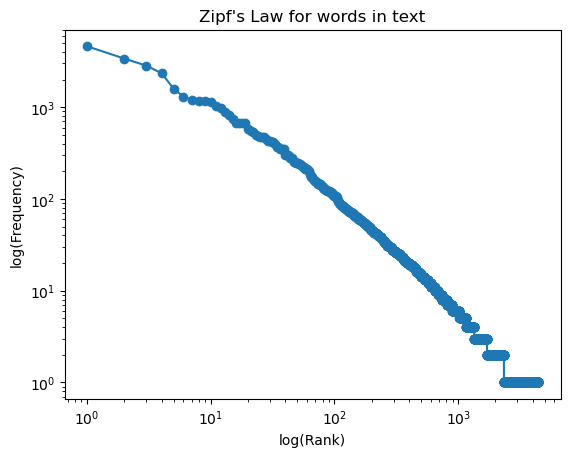

In [10]:
# your code here
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def zipf_law(words):
    word_frequency = Counter(words)
    sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
    rank = np.array([i+1 for i in range(len(sorted_word_frequency))])
    frequency = np.array([x[1] for x in sorted_word_frequency])

    plt.loglog(rank, frequency, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("log(Rank)")
    plt.ylabel("log(Frequency)")
    plt.title("Zipf's Law for words in text")
    plt.show()

zipf_law(final_dict)
doc_dict = set(final_dict)
doc_dict = list(doc_dict)
doc_dict.sort()

What do you observe? Explain.  

Zipf's law states that the frequency of a word in a text corpus is proportional to its rank in the frequency table of the corpus, with the most frequent word having a rank of 1. This means that the most frequent word in a corpus is likely to be much more common than the second most frequent word, which is in turn much more common than the third most frequent word, and so on.  
From the above plot, we can observe a slope that decreases linearly from left to right. This slope represents the power-law relationship between frequency and rank. The steeper the slope, the stronger the relationship. As the slope is close to -1, this means that the frequency of elements decreases very rapidly as their rank increases.

# Part 2: Boolean Retrieval (30 points)

In this part you will build an inverted index to support Boolean retrieval. You should use the (1) + (2) tokenization strategy from above (Remove background vocals + Lemmatization). 

We only require your index to support AND queries. In other words, your index does not have to support OR, NOT, or parentheses. Also, we do not explicitly expect to see AND in queries, e.g., when we query **relational model**, your search engine should treat it as **relational** AND **model**.

Search for the queries below using your index and print out matching documents (for each query, print out 5 matching documents):
* time
* never know
* make no sense

Recall, that you should apply the exact same pre-processing strategies to the query as we do to the documents. 

The output should like this:
* DocumentID Document

To make our life easier, please output the DocumentIDs in alphabetical order.

In [11]:
from collections import defaultdict

class InvertedIndex: 
    def __init__(self):
        self.index = defaultdict(list)

    def add_document(self, doc_id, terms):
        for term in set(terms):
            self.index[term].append(doc_id)
    
    def search(self, query):
        terms = query.split()
        results = None

        for term in terms:
            if term not in self.index:
                return []
            if results is None:
                results = set(self.index[term])
            else:
                results &= set(self.index[term])
                
        results = list(results)
        results.sort()
        return results

index = InvertedIndex()

# Add all documents to the index
for i in range(len(df)):
    index.add_document(df['DocumentID'][i], df['Tokens'][i])

In [12]:
import pandas as pd

# list of words to query
query = ["time", "never know", "make no sense"]
queries = []

# Perform remove bg vocals and lemmatization
for q in query:
    q = remove_bgvocals(q)
    q = list(q.split())
    q = lemmatize_words(q)
    queries.append(q)
queries

# Function to build query from tokens to search
def combine_words_for_and_query(words):
    return " ".join(words)

search_queries = []
for query in queries:
    search_queries.append(combine_words_for_and_query(query))

Now show the results for the query: `time`

In [13]:
#Top 5 results for Query1
print("5 docs in alphabetical order for Query: {}\n{}".format(search_queries[0], index.search(search_queries[0])[:5]))

5 docs in alphabetical order for Query: time
['5-seconds-of-summer-close-as-strangers-lyrics', 'Alessia-cara-outlaws-lyrics', 'Alicia-keys-fallin-lyrics', 'Alicia-keys-no-one-lyrics', 'Anitta-goals-lyrics']


Now show the results for the query: `never know`


In [14]:
#Top 5 results for Query2
print("5 docs in alphabetical order for Query: {}\n{}".format(search_queries[1], index.search(search_queries[1])[:5]))

5 docs in alphabetical order for Query: never know
['2pac-u-r-ripping-us-apart-dedicated-2-crack-annotated', '5-seconds-of-summer-heartbreak-girl-lyrics', 'Alessia-cara-outlaws-lyrics', 'Alessia-cara-the-other-side-lyrics', 'Allie-x-sunflower-synth-reprise-lyrics']


Now show the results for the query: `make no sense`

In [15]:
#Top 5 results for Query3
print("5 docs in alphabetical order for Query: {}\n{}".format(search_queries[2], index.search(search_queries[2])[:5]))

5 docs in alphabetical order for Query: make no sense
['Bring-me-the-horizon-mother-tongue-lyrics', 'Devlin-all-along-the-watchtower-lyrics', 'Florence-the-machine-all-this-and-heaven-too-lyrics', 'Kid-cudi-ghost-lyrics', 'Linkin-park-one-step-closer-lyrics']


## Observations (6 points)
Could your boolean search engine find relevant documents for these queries? What is the impact of the pre-processing options? Do they improve your search quality?

Yes, a boolean search engine can find relevant documents for queries by using the inverted index to efficiently locate documents that match the query terms.  

The impact of pre-processing options such as lemmatization can greatly improve the quality of the search results in a boolean retrieval system. By reducing words to their base form, lemmatization can make it easier for the search engine to match query terms with terms in the documents, as well as reduce the size of the index. This can lead to more relevant results, as well as faster and more efficient searches.  

Pre-processing options improved the search quality by reducing the noise in the index and making the search more focused on the meaningful terms in the query and documents.  

# Part 3: Ranking Documents (40 points) 

In this part, your job is to rank the documents rather than just provide set-based results as in Boolean Retrieval.

### A: Ranking with simple sums of TF-IDF scores (10 points) 
For a multi-word query, we rank documents by a simple sum of the TF-IDF scores for the query terms in the document.
TF is the log-weighted term frequency $1+log(tf)$; and IDF is the log-weighted inverse document frequency $log(\frac{N}{df})$

**Output:**
You should output the top-5 results plus the TF-IDF sum score of each of these documents. 

The output should be like this:

Rank Scores DocumentID Document 

In [16]:
import math

# Search number of times a term appears in document
def term_frequency(document, term):
    return 1 + math.log(document.count(term))/math.log(10)

# Counts number of rows a term appear in Tokens
def count_rows(df, term):
    return sum([1 for row in df['Tokens'] if term in row])

# Return inverted index of a term
def idf(term, df):
    if count_rows(df, term) == 0:
        return 0
    else:
        return math.log(len(df)/count_rows(df, term))/math.log(10)


Now show the results for the query: `time`

In [17]:
# your code here
#Get all relevant docs from boolean retrival
query = search_queries[0]
result = index.search(query)

#Gives only those docs which are relevant
filtered_df = df[df['DocumentID'].isin(result)]
filtered_df['Query_Score'] = 0
for term in query.split():
    idf_score = float(idf(term, df))
    filtered_df['Query_Score'] += filtered_df.apply(lambda row: term_frequency(row['Tokens'], term), axis=1)*idf_score
filtered_df = filtered_df.sort_values(by="Query_Score", ascending=False).reset_index(drop=True)
filtered_df['Rank'] = filtered_df['Query_Score'].rank(ascending=False)
filtered_df.head()

,DocumentID,Document,Tokens,Query_Score,Rank
0,Derek-minor-until-the-end-of-time-lyrics,time is the fourth dimension and a measure ...,"[time, is, the, fourth, dimension, and, a, mea...",0.997799,1.0
1,John-legend-for-the-first-time-lyrics,is that music in my ear it's like i heard...,"[is, that, music, in, my, ear, it, is, like, i...",0.938886,2.0
2,Method-man-if-time-is-money-fly-navigation-lyrics,"uh, yeah choose a side look, vibe with me...","[uh, ,, yeah, choose, a, side, look, ,, vibe, ...",0.900474,3.0
3,Linkin-park-from-the-inside-lyrics,"i don't know who to trust, no surprise ever...","[i, do, not, know, who, to, trust, ,, no, surp...",0.810657,5.0
4,Partynextdoor-not-nice-lyrics,oh-oh-oh-oh oh-oh-oh-oh you've got some v...,"[oh-oh-oh-oh, oh-oh-oh-oh, you, have, got, som...",0.810657,5.0


Now show the results for the query: `never know`

In [18]:
# your code here
query = search_queries[1]
result = index.search(query)

#Gives only those docs which are relevant
filtered_df = df[df['DocumentID'].isin(result)]
filtered_df['Query_Score'] = 0

for term in query.split():
    idf_score = float(idf(term, df))
    filtered_df['Query_Score'] += filtered_df.apply(lambda row: term_frequency(row['Tokens'], term), axis=1)*idf_score
filtered_df = filtered_df.sort_values(by="Query_Score", ascending=False).reset_index(drop=True)
filtered_df['Rank'] = filtered_df['Query_Score'].rank(ascending=False)
filtered_df.head()

,DocumentID,Document,Tokens,Query_Score,Rank
0,Skrillex-pretty-bye-bye-lyrics,i know you are trouble but i can't seem to ...,"[i, know, you, are, trouble, but, i, can, not,...",1.295128,1.0
1,Derek-minor-until-the-end-of-time-lyrics,time is the fourth dimension and a measure ...,"[time, is, the, fourth, dimension, and, a, mea...",1.145859,2.0
2,Billie-eilish-8-lyrics,"wait a minute, let me finish i know you don...","[wait, a, minute, ,, let, me, finish, i, know,...",1.135649,3.0
3,Bring-me-the-horizon-mother-tongue-lyrics,i didn't see it coming but i never really ...,"[i, did, not, see, it, coming, but, i, never, ...",1.094982,4.0
4,Marilyn-manson-coma-black-lyrics,"part i: eden eye ""a loved one laid his hea...","[part, i, :, eden, eye, ``, a, loved, one, lai...",1.093421,5.0


Now show the results for the query: `make no sense`

In [19]:
# your code here
query = search_queries[2]
result = index.search(query)

#Gives only those docs which are relevant
filtered_df = df[df['DocumentID'].isin(result)]
filtered_df['Query_Score'] = 0
for term in query.split():
    idf_score = float(idf(term, df))
    filtered_df['Query_Score'] += filtered_df.apply(lambda row: term_frequency(row['Tokens'], term), axis=1)*idf_score
filtered_df = filtered_df.sort_values(by="Query_Score", ascending=False).reset_index(drop=True)
filtered_df['Rank'] = filtered_df['Query_Score'].rank(ascending=False)
filtered_df.head()

,DocumentID,Document,Tokens,Query_Score,Rank
0,Bring-me-the-horizon-mother-tongue-lyrics,i didn't see it coming but i never really ...,"[i, did, not, see, it, coming, but, i, never, ...",4.482244,1.0
1,Florence-the-machine-all-this-and-heaven-too-l...,and the heart is hard to translate it has a...,"[and, the, heart, is, hard, to, translate, it,...",3.278860,2.0
2,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha y...","[yeah, ,, woah-woah, ,, oh, yeah, ,, woah-woah...",3.085164,3.0
3,Linkin-park-one-step-closer-lyrics,i cannot take this anymore saying everythin...,"[i, can, not, take, this, anymore, saying, eve...",3.050704,4.0
4,Devlin-all-along-the-watchtower-lyrics,there must be some way out of here said the...,"[there, must, be, some, way, out, of, here, sa...",2.680610,5.0


### B: Ranking with vector space model with TF-IDF (10 points) 

**Cosine:** You should use cosine as your scoring function. 

**TFIDF:** For the document vectors, use the standard TF-IDF scores as introduced in A. For the query vector, use simple weights (the raw term frequency). For example:
* query: never $\rightarrow$ (1)
* query: never know $\rightarrow$ (1, 1)

**Output:**
You should output the top-5 results plus the cosine score of each of these documents.  

The output should be like this:

Rank Scores DocumentID Document 

---

You can additionally assume that your queries will contain at most three words. Be sure to normalize your vectors as part of the cosine calculation!

In [20]:
def idf_all_terms(df, doc_dict):
    idf_score = []
    for term in doc_dict:
        idf_score.append(idf(term, df))
    return idf_score

def doc_tf_idf(df, doc_dict):
    idf_score = idf_all_terms(df, doc_dict)
    df['tf_idf'] = [[] for _ in range(len(df))]
    for i in range(len(df)):
        scores = [0 for i in range(0,len(doc_dict))]
        freq = [0 for i in range(0,len(doc_dict))]
        
        # Update Frequency
        for word in df['Tokens'][i]:
            index = doc_dict.index(word) 
            freq[index] += 1
            
        # Update Scores
        for word in df['Tokens'][i]:
            index = doc_dict.index(word) 
            scores[index] = (1 + (math.log(freq[index])/math.log(10)))*idf_score[index]
        
        normalized_value = math.sqrt(sum([score**2 for score in scores]))
        scores = [score/normalized_value for score in scores]
        
        # Update the dataframe
        df['tf_idf'][i] = scores
    

In [21]:
doc_tf_idf(df, doc_dict)

In [22]:
#Index and Normalize Query
def index_norm_query(text, doc_dict):
    terms = text.split()
    query_score = [0 for i in range(0,len(doc_dict))]
    for term in terms:
        index = doc_dict.index(term)
        query_score[index] += 1
    normalized_value = math.sqrt(sum([score**2 for score in query_score]))
    query_score = [score/normalized_value for score in query_score]
    return query_score

Now show the results for the query: `time`

In [23]:
# your code here
query_vector = index_norm_query(search_queries[0], doc_dict)
df['Score'] = [sum([i*j for i,j in zip(row, query_vector)]) for row in df['tf_idf']]
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,John-legend-for-the-first-time-lyrics,is that music in my ear it's like i heard...,"[is, that, music, in, my, ear, it, is, like, i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.101289,1.0
1,The-beatles-carry-that-weight-lyrics,"boy, you're gonna carry that weight carry t...","[boy, ,, you, are, going, to, carry, that, wei...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.096126,2.0
2,The-beatles-ill-follow-the-sun-lyrics,"one day, you'll look to see i've gone for t...","[one, day, ,, you, will, look, to, see, i, hav...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.076795,3.0
3,Lana-del-rey-burnt-norton-interlude-lyrics,time present and time past are both perhaps...,"[time, present, and, time, past, are, both, pe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.073668,4.0
4,Linkin-park-from-the-inside-lyrics,"i don't know who to trust, no surprise ever...","[i, do, not, know, who, to, trust, ,, no, surp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.071755,5.0


Now show the results for the query: `never know`

In [24]:
# your code here
query_vector = index_norm_query(search_queries[1], doc_dict)
df['Score'] = [sum([i*j for i,j in zip(row, query_vector)]) for row in df['tf_idf']]
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Skrillex-pretty-bye-bye-lyrics,i know you are trouble but i can't seem to ...,"[i, know, you, are, trouble, but, i, can, not,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176...",0.073648,1.0
1,John-legend-made-to-love-lyrics,i was sent here for you we were made to l...,"[i, wa, sent, here, for, you, we, were, made, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.073598,2.0
2,Billie-eilish-8-lyrics,"wait a minute, let me finish i know you don...","[wait, a, minute, ,, let, me, finish, i, know,...","[0.0, 0.0, 0.0, 0.06911137531833073, 0.0602141...",0.068107,3.0
3,Panic-at-the-disco-girls-girls-boys-lyrics,i don't want to hear you got a boyfriend so...,"[i, do, not, want, to, hear, you, got, a, boyf...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.063735,4.0
4,Muse-aftermath-lyrics,war is all around i'm growing tired of figh...,"[war, is, all, around, i, am, growing, tired, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.059311,5.0


Now show the results for the query: `make no sense`

In [25]:
# your code here
query_vector = index_norm_query(search_queries[2], doc_dict)
df['Score'] = [sum([i*j for i,j in zip(row, query_vector)]) for row in df['tf_idf']]
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Linkin-park-one-step-closer-lyrics,i cannot take this anymore saying everythin...,"[i, can, not, take, this, anymore, saying, eve...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.185360,1.0
1,Bring-me-the-horizon-mother-tongue-lyrics,i didn't see it coming but i never really ...,"[i, did, not, see, it, coming, but, i, never, ...","[0.0, 0.0, 0.0, 0.0, 0.08485694890580205, 0.0,...",0.167635,2.0
2,Shawn-mendes-act-like-you-love-me-lyrics,"so you leave tomorrow, just sleep the night...","[so, you, leave, tomorrow, ,, just, sleep, the...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.120528,3.0
3,Florence-the-machine-all-this-and-heaven-too-l...,and the heart is hard to translate it has a...,"[and, the, heart, is, hard, to, translate, it,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.118449,4.0
4,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha y...","[yeah, ,, woah-woah, ,, oh, yeah, ,, woah-woah...","[0.0, 0.0, 0.0, 0.046603625175871494, 0.0, 0.0...",0.101871,5.0


### C: Ranking with BM25 (10 points) 
Finally, let's try the BM25 approach for ranking. Refer to https://en.wikipedia.org/wiki/Okapi_BM25 for the specific formula. You could choose k_1 = 1.2 and b = 0.75 but feel free to try other options.

**Output:**
You should output the top-5 results plus the BM25 score of each of these documents.  

The output should be like this:

Rank Scores DocumentID Document

In [26]:
# Function to calculate BM25
def bm25_score(df, column, query, k1=1.2, b=0.75):
    N = len(df)
    avg_len = sum(df[column].apply(len)) / N
    scores = []
    for i in range(N):
        document = df[column].iloc[i]
        score = 0
        for word in query.split():
            n = sum(1 for d in df[column] if word in d)
            idf = math.log(N/n)/math.log(10)
            f = document.count(word)
            score += idf * (f * (k1 + 1) / (f + k1 * (1 - b + b * len(document) / avg_len)))
        scores.append(score)
    return pd.Series(scores, index=df.index)

Now show the results for the query: `time`

In [27]:
# your code here
df['Score'] = bm25_score(df, 'Tokens', search_queries[0], 1.2, 0.75)
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,John-legend-for-the-first-time-lyrics,is that music in my ear it's like i heard...,"[is, that, music, in, my, ear, it, is, like, i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.880378,1.0
1,Lana-del-rey-burnt-norton-interlude-lyrics,time present and time past are both perhaps...,"[time, present, and, time, past, are, both, pe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.873321,2.0
2,Sza-pray-lyrics,"pray for yourself one time one time, time ...","[pray, for, yourself, one, time, one, time, ,,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.849563,3.0
3,System-of-a-down-thetawaves-lyrics,the unsettled mind is at times an ally leav...,"[the, unsettled, mind, is, at, time, an, ally,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.847497,4.0
4,Linkin-park-from-the-inside-lyrics,"i don't know who to trust, no surprise ever...","[i, do, not, know, who, to, trust, ,, no, surp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.834475,5.0


Now show the results for the query: `never know`

In [28]:
# your code here
df['Score'] = bm25_score(df, 'Tokens', search_queries[1], 1.2, 0.75)
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Skrillex-pretty-bye-bye-lyrics,i know you are trouble but i can't seem to ...,"[i, know, you, are, trouble, but, i, can, not,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176...",1.264629,1.0
1,Billie-eilish-8-lyrics,"wait a minute, let me finish i know you don...","[wait, a, minute, ,, let, me, finish, i, know,...","[0.0, 0.0, 0.0, 0.06911137531833073, 0.0602141...",1.249621,2.0
2,Panic-at-the-disco-girls-girls-boys-lyrics,i don't want to hear you got a boyfriend so...,"[i, do, not, want, to, hear, you, got, a, boyf...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.169681,3.0
3,Marina-the-archetypes-lyrics,"housewife, beauty queen, homewrecker, idle t...","[housewife, ,, beauty, queen, ,, homewrecker, ...","[0.0, 0.0, 0.15988212494129256, 0.0, 0.0622348...",1.137158,4.0
4,Alessia-cara-outlaws-lyrics,"run, run like the devil’s behind us run to ...","[run, ,, run, like, the, devil, ’, s, behind, ...","[0.0, 0.0, 0.0, 0.03263832494120442, 0.0, 0.0,...",1.134210,5.0


Now show the results for the query: `make no sense`

In [29]:
# your code here
df['Score'] = bm25_score(df, 'Tokens', search_queries[2], 1.2, 0.75)
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Bring-me-the-horizon-mother-tongue-lyrics,i didn't see it coming but i never really ...,"[i, did, not, see, it, coming, but, i, never, ...","[0.0, 0.0, 0.0, 0.0, 0.08485694890580205, 0.0,...",4.327209,1.0
1,Linkin-park-one-step-closer-lyrics,i cannot take this anymore saying everythin...,"[i, can, not, take, this, anymore, saying, eve...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.758132,2.0
2,Florence-the-machine-all-this-and-heaven-too-l...,and the heart is hard to translate it has a...,"[and, the, heart, is, hard, to, translate, it,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.483398,3.0
3,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha y...","[yeah, ,, woah-woah, ,, oh, yeah, ,, woah-woah...","[0.0, 0.0, 0.0, 0.046603625175871494, 0.0, 0.0...",3.056984,4.0
4,Shawn-mendes-act-like-you-love-me-lyrics,"so you leave tomorrow, just sleep the night...","[so, you, leave, tomorrow, ,, just, sleep, the...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.355055,5.0


### Discussion (10 points)
Briefly discuss the differences you see between the three methods. You should try additional queries beyond the ones we list. Is there a ranking approach you prefer? Explain and give concrete examples.


#### QUERY tested: "will you be there" answer expected: "Michael-jackson-will-you-be-there-lyrics"

In [30]:
query = "will you be there"

In [31]:
# TF-IDF
result = index.search(query)

#Gives only those docs which are relevant
filtered_df = df[df['DocumentID'].isin(result)]
filtered_df['Query_Score'] = 0

for term in query.split():
    idf_score = float(idf(term, df))
    filtered_df['Query_Score'] += filtered_df.apply(lambda row: term_frequency(row['Tokens'], term), axis=1)*idf_score
filtered_df = filtered_df.sort_values(by="Query_Score", ascending=False).reset_index(drop=True)
filtered_df['Rank'] = filtered_df['Query_Score'].rank(ascending=False)
filtered_df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank,Query_Score
0,Frank-ocean-godspeed-dvsn-remix-lyrics,i will always love you how i do let go of a...,"[i, will, always, love, you, how, i, do, let, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.0,1.951193
1,Rihanna-umbrella-lyrics,"uh-huh, uh-huh uh-huh, uh-huh uh-huh, uh-...","[uh-huh, ,, uh-huh, uh-huh, ,, uh-huh, uh-huh,...","[0.0, 0.0, 0.0, 0.052764938707345325, 0.0, 0.0...",0.435229,2.0,1.856156
2,Skylar-grey-tower-dont-look-down-lyrics,you're high up on the tower now don’t look ...,"[you, are, high, up, on, the, tower, now, do, ...","[0.0, 0.0, 0.0, 0.05436794727557258, 0.0, 0.0,...",1.396168,3.0,1.836598
3,Lin-manuel-miranda-what-the-heck-i-gotta-do-ly...,the plan was called operation d-minus. and ...,"[the, plan, wa, called, operation, d-minus, .,...","[0.08943780129527809, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.669664,4.0,1.835006
4,Kanye-west-low-lights-lyrics,you want me to give you a testimony about m...,"[you, want, me, to, give, you, a, testimony, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.101982,5.0,1.828740


In [32]:
# VectorSpace with TF-IDF
query_vector = index_norm_query(query, doc_dict)
df['Score'] = [sum([i*j for i,j in zip(row, query_vector)]) for row in df['tf_idf']]
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Kanye-west-low-lights-lyrics,you want me to give you a testimony about m...,"[you, want, me, to, give, you, a, testimony, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.084153,1.0
1,Imagine-dragons-release-lyrics,twenty miles from anyone set my sights on t...,"[twenty, mile, from, anyone, set, my, sight, o...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.083514,2.0
2,Alicia-keys-no-one-lyrics,i just want you close where you can stay fo...,"[i, just, want, you, close, where, you, can, s...","[0.0, 0.0, 0.0, 0.08539408657035345, 0.0, 0.0,...",0.082507,3.0
3,Frank-ocean-godspeed-dvsn-remix-lyrics,i will always love you how i do let go of a...,"[i, will, always, love, you, how, i, do, let, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.079368,4.0
4,Skylar-grey-tower-dont-look-down-lyrics,you're high up on the tower now don’t look ...,"[you, are, high, up, on, the, tower, now, do, ...","[0.0, 0.0, 0.0, 0.05436794727557258, 0.0, 0.0,...",0.075445,5.0


In [33]:
#BM-25
df['Score'] = bm25_score(df, 'Tokens', query, 1.2, 0.75)
df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)
df['Rank'] = df['Score'].rank(ascending=False)
df.head()

,DocumentID,Document,Tokens,tf_idf,Score,Rank
0,Frank-ocean-godspeed-dvsn-remix-lyrics,i will always love you how i do let go of a...,"[i, will, always, love, you, how, i, do, let, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.012258,1.0
1,Michael-jackson-will-you-be-there-lyrics,hold me like the river jordan and i will th...,"[hold, me, like, the, river, jordan, and, i, w...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.005938,2.0
2,Kanye-west-low-lights-lyrics,you want me to give you a testimony about m...,"[you, want, me, to, give, you, a, testimony, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.934673,3.0
3,Skylar-grey-tower-dont-look-down-lyrics,you're high up on the tower now don’t look ...,"[you, are, high, up, on, the, tower, now, do, ...","[0.0, 0.0, 0.0, 0.05436794727557258, 0.0, 0.0,...",1.930400,4.0
4,Miley-cyrus-if-we-were-a-movie-lyrics,"uh oh there you go again, talking cinematic...","[uh, oh, there, you, go, again, ,, talking, ci...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.844927,5.0


### The advantages and disadvantages of each of the algorithms tried:

Using the TF-IDF algorithm, lyrics that are more pertinent to the search query are given a better ranking. This algorithm considers the term frequency (TF) and inverse document frequency (IDF) of the words in the lyrics. However, because it does not use the lyrics' contextual information, it might not perform well in situations when the context is crucial for the search results.

Using TF-IDF to calculate the cosine similarity of the vectors that represent the query and the lyrics, this technique determines how similar the query and the lyrics are to one another. When looking for lyrics that are semantically related to a query, this approach to song lyric search might be extremely useful.

BM25: Similar to TF-IDF, BM25 is a probabilistic model that determines the relevance score between the search term and the lyrics while accounting for TF and IDF as well as other factors. Because it provides a more comprehensive approach to addressing term frequency and inverse document frequency, BM25 may occasionally be more effective than TF-IDF.

### Preferred Ranking Approach

As discussed advantages and disadvantages above, and looking at the results for given queries, BM25 algorithm worked better. 
I tried with custom query where answer is expected to be 'Michael-jackson-will-you-be-there-lyrics', only BM25 returned the song in top 5 results.

# Part 4: Cool Extension (10 points) 

Finally, we give you an opportunity to explore some more sophisticated approach to your search engine. This is your chance to show off something you find interesting. For example, you might:


*   Add a positional index so you can support phrase queries
*   Implement a permuterm index for wildcard queries
*   Incorporate spell correction
*   Index all of the lyrics at https://www.cs.cornell.edu/~arb/data/genius-expertise/ and demonstrate an efficient implementation
*   Try a more advanced ranking approach
*   ...

We will grade this last part according to effort, creativity, and impact.



In [34]:
# Spell Correction
def correct_spellings(word, dictionary):
    word = word.lower()
    closest_word = word
    closest_distance = float('inf')
    for dict_word in dictionary:
        distance = edit_distance(word, dict_word)
        if distance < closest_distance:
            closest_distance = distance
            closest_word = dict_word
    return closest_word

def edit_distance(word1, word2):
    m, n = len(word1), len(word2)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif word1[i - 1] == word2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
    return dp[m][n]

queries = ["willl ypu bee there", "hullo warld", "time", "loveu", "neper knou", "make no sence"]
for query in queries:
    corrected_query = ""
    for term in query.split():
        corrected_query += str(correct_spellings(term, doc_dict)) + " "
    print("Corrected Query is:", corrected_query)

Corrected Query is: will you be there 
Corrected Query is: hello world 
Corrected Query is: time 
Corrected Query is: love 
Corrected Query is: never know 
Corrected Query is: make no sense 


In [35]:
# Positional Index to support adjacent phrase queries
class PositionalIndex:
    def __init__(self, documents, doc_ids):
        self.documents = documents
        self.doc_ids = doc_ids
        self.index = {}
        for i, doc in enumerate(documents):
            words = doc
            for j, word in enumerate(words):
                if word not in self.index:
                    self.index[word] = {}
                if doc_ids[i] not in self.index[word]:
                    self.index[word][doc_ids[i]] = []
                self.index[word][doc_ids[i]].append(j)

    def search(self, query):
        query_terms = query.split()
        matching_doc_ids = []
        if query_terms[0] in self.index:
            for doc_id, positions in self.index[query_terms[0]].items():
                for pos in positions:
                    found = True
                    for i in range(1, len(query_terms)):
                        if doc_id not in self.index.get(query_terms[i], {}) or pos + i not in self.index[query_terms[i]][doc_id]:
                            found = False
                            break
                    if found:
                        matching_doc_ids.append(doc_id)
                        break
        return matching_doc_ids

pos_index = PositionalIndex(df['Tokens'].tolist(), df['DocumentID'].tolist())

query = 'will you be there'
matching_docs = pos_index.search(query)
print(matching_docs)


['Michael-jackson-will-you-be-there-lyrics']


### Reason to consider spell check and positional index (adjacent words):
Most of the users will remember lyrics as adjacent phrases. So its better to check if the words appear in order for a phrase query by user.
While typing the user might make typos. So check for those as well.
Look at example below.

In [36]:
query = "will ypu bee"
corrected_query = ""
for term in query.split():
    corrected_query += str(correct_spellings(term, doc_dict)) + " "
print("Corrected Query is:", corrected_query)
matching_docs = pos_index.search(corrected_query)
print("Matching Documnets are:", matching_docs)

Corrected Query is: will you be 
Matching Documnets are: ['Michael-jackson-will-you-be-there-lyrics', 'Lana-del-rey-caught-you-boy-lyrics']


In [37]:
print("Now our search becomes easy and limited to less number of documnets to rank" "\U0001f600")

Now our search becomes easy and limited to less number of documnets to rank😀


# Collaboration Declarations

** You should fill out your collaboration declarations here.**

**Reminder:** You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by filling out the Collaboration Declarations at the bottom of this notebook.

Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.

I found helpful code on stack overflow for reading json file  
I found list of punctuation that can be removed on google  
I found helpful code on google to remove stopwords  
I found helpful first draft of structured code for inverted index to support Boolean Retrieval on chatGPT  
I found helpful first draft of theoretical questions like why zipf's law, comparing 3 algorithms on chatGPT  